# SinGAN

This notebook is for implementing __SinGAN: Learning a Generative Model from a Single Natural Image__ from the paper [SinGAN: Learning a Generative Model from a Single Natural Image](https://arxiv.org/pdf/1905.01164.pdf) with [Tensorflow](https://www.tensorflow.org/).  
Datasets are in [here](https://github.com/tamarott/SinGAN/tree/master/Input)  
Reference: [tamarrot's github](https://github.com/tamarott/SinGAN)(official implementation with pytorch)

## IMPORT MODULE

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import datetime

## DEFINE PARAMETER

In [3]:
algorithm = 'SinGAN'
num_epoch = [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
filters = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
learning_rate = 0.0005
batch_size = 1
iter_grad = 3

num_scale = 9
noise_scale = 1
noise_amp = 0.1
scale = 3/4

L_rec = 10
L_adv = 1

train_model = True
load_model = False

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")
save_path = './savegraph/' + date_time + "_" + algorithm + "/save"
load_path = './savegraph/BALLOON_finish/save'

# WGAN_GP Parateter
D_lambda = 1

## IMPORT DATASET

In [4]:
def img_norm(img):
    return (img - (255/2)) / (255/2)

def denorm(img):
    out = (img + 1) / 2
    return np.clip(out, 0, 1)

In [5]:
input_img = glob.glob('./image/balloon.jpeg')
input_img

['./image/balloon.jpeg']

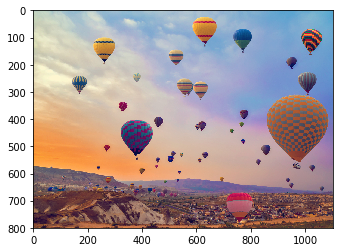

In [6]:
input_img = glob.glob('./image/balloon.jpeg')
sample = cv2.cvtColor(cv2.imread(input_img[0]), cv2.COLOR_BGR2RGB)
img_size = np.shape(sample)
img_size_set = []

img_N = []
for i in range(num_scale):
    img_N.append(cv2.resize(sample, (int(img_size[1]*(scale**i)), int(img_size[0]*(scale**i)))))
    img_size_set.append(np.shape(img_N[i]))
    
plt.imshow(img_N[0])
img_N = img_norm(np.array(img_N))[::-1]
img_size_set = img_size_set[::-1]

## UTILITY

In [7]:
# Utility for batch size image
def img_resize(img, img_size):
    out = [cv2.resize(img, (img_size[1], img_size[0]))]
    return out

def img_noise(img_size):
    noise_amp = 0.1
    out = [np.random.uniform(-1,1,[img_size[0], img_size[1], img_size[2]])*noise_amp]
    return out

def noise_fix(img_size):
    out = []
    for i in range(num_scale):
        if i < noise_scale:
            out.append(img_noise(img_size[i]))
        else:
            out.append([np.zeros(img_size[i])])
    return out

## NETWORK

In [8]:
class SinGAN():
    def __init__(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=config)
        self.GAN()
        
    def conv_block(self, inp, n_filter, n_kernel, norm, act, i):
        conv = tf.layers.conv2d(inp, filters=n_filter, kernel_size=n_kernel, strides=1, padding="SAME", name="conv_"+i,
                                kernel_initializer=tf.initializers.glorot_uniform())
        if norm == "B":
            conv = tf.layers.batch_normalization(conv)
        elif norm == "I":
            conv = tf.contrib.layers.instance_norm(conv)
            
        if act == "L":
            conv = tf.nn.leaky_relu(conv)
        elif act == "T":
            conv = tf.nn.tanh(conv)
            
        return conv

    def generator(self, img, noise, n_filter, net_name):
        inp = img + noise
        with tf.variable_scope(net_name, reuse=tf.AUTO_REUSE):
            conv1 = self.conv_block(inp, n_filter*8, 3, "I", "L", "1")
            conv2 = self.conv_block(conv1, n_filter*4, 3, "I", "L", "2")
            conv3 = self.conv_block(conv2, n_filter*2, 3, "I", "L", "3")
            conv4 = self.conv_block(conv3, n_filter, 3, "I", "L", "4")
            
            ## Receptive field size is 11x11
            img_gen = self.conv_block(conv4, 3, 3, "I", "T", "5")
            out = img_gen + img
        return out

    def discriminator(self, img, n_filter, net_name):
        with tf.variable_scope(net_name, reuse=tf.AUTO_REUSE):
            conv1 = self.conv_block(img, n_filter*1, 3, "B", "L", "1")
            conv2 = self.conv_block(conv1, n_filter*2, 3, "B", "L", "2")
            conv3 = self.conv_block(conv2, n_filter*4, 3, "B", "L", "3")
            conv4 = self.conv_block(conv3, n_filter*8, 3, "B", "L", "4")
            conv5 = self.conv_block(conv4, 1, 3, "", "", "5")
            
            ## Receptive field size is 11x11
            logit = tf.reduce_mean(conv5)
        return logit
    
    def adv_loss(self, real, fake, D_real, D_fake, n_filter, scale):
        # WGAN-GP Loss
        eps = tf.random_uniform(shape=tf.shape(real),minval=0.0, maxval=1.0)
        x_hat = (eps * real) + ((1-eps) * fake)
        D_hat = self.discriminator(x_hat, n_filter, "dis_" + str(scale))
        grad = tf.gradients(D_hat, [x_hat])[0]
        GP = D_lambda * tf.square(tf.norm(grad, ord=2) - 1)
        
        D_loss = D_fake - D_real + GP
        G_loss = - D_fake
        return G_loss, D_loss
        
    def rec_loss(self, real, fake):
        # MSE Loss
        G_loss = tf.reduce_mean(tf.square(real - fake))
        return G_loss
        
    def GAN(self):
        self.learning_rate = tf.placeholder(shape=[], dtype=tf.float32)
        self.is_train = tf.placeholder(dtype=tf.bool)
        
        self.inp = {}
        self.noise = {}
        self.inp_fix = {}
        self.noise_fix = {}
        self.real = {}
        self.fake = {}
        self.fake_fix = {}
        self.real_D = {}
        self.fake_D = {}
        
        self.loss_gen = {}
        self.loss_dis = {}

        for i in range(num_scale):
            self.inp[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)
            self.inp_fix[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)
            
            self.noise[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)
            self.noise_fix[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)
            
            self.real[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)

            self.fake[str(i)] = self.generator(self.inp[str(i)], self.noise[str(i)], filters[i], "gen_" + str(i))
            self.fake_fix[str(i)] = self.generator(self.inp_fix[str(i)], self.noise_fix[str(i)], filters[i], "gen_" + str(i))
            
            self.real_D[str(i)] = self.discriminator(self.real[str(i)], filters[i], "dis_" + str(i))
            self.fake_D[str(i)] = self.discriminator(self.fake[str(i)], filters[i], "dis_" + str(i))
      
            adv_gen, adv_dis = self.adv_loss(self.real[str(i)], self.fake[str(i)],
                                             self.real_D[str(i)], self.fake_D[str(i)],
                                             filters[i], i)
        
            rec_gen = self.rec_loss(self.real[str(i)], self.fake_fix[str(i)])

            self.loss_gen[str(i)] = L_adv*adv_gen + L_rec*rec_gen
            self.loss_dis[str(i)] = L_adv*adv_dis
            
        self.var_all = tf.trainable_variables()
        self.var_gen = {}
        self.var_dis = {}
        self.opt_gen = {}
        self.opt_dis = {}
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        for i in range(num_scale):
            self.var_gen[str(i)] = [var for var in self.var_all if "gen_" + str(i) in var.name]
            self.var_dis[str(i)] = [var for var in self.var_all if "dis_" + str(i) in var.name]
            
            opt_gen = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.5, beta2=0.999)
            opt_dis = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.5, beta2=0.999)
            
            with tf.control_dependencies(update_ops):
                self.opt_gen[str(i)] = opt_gen.minimize(self.loss_gen[str(i)], var_list=self.var_gen[str(i)])
                self.opt_dis[str(i)] = opt_dis.minimize(self.loss_dis[str(i)], var_list=self.var_dis[str(i)])

## INITIALIZATION

In [9]:
# Initialize variables
network = SinGAN()
init = tf.global_variables_initializer()
network.sess.run(init)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


## LOAD MODEL

In [10]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(network.sess, load_path)

## TRAIN

Scale: 0 / Epoch: 250 / G Loss: 2867.62329 / D Loss: -344.07394


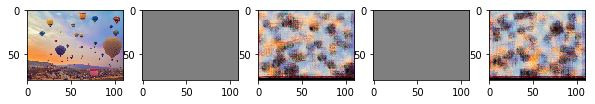

Scale: 0 / Epoch: 500 / G Loss: 3721.88770 / D Loss: -472.10471


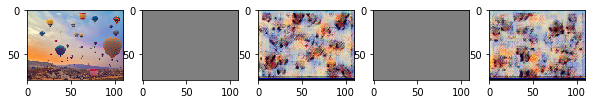

Scale: 0 / Epoch: 750 / G Loss: 3359.56372 / D Loss: -447.26263


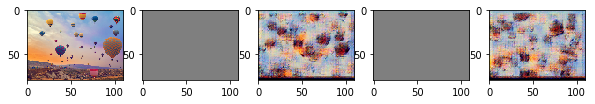

Scale: 0 / Epoch: 1000 / G Loss: 3857.05811 / D Loss: -430.68582


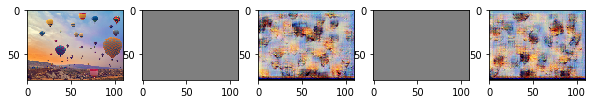

Scale: 0 / Epoch: 1250 / G Loss: 3531.80811 / D Loss: -512.56592


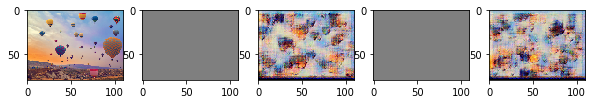

Scale: 0 / Epoch: 1500 / G Loss: 3393.07568 / D Loss: -432.54272


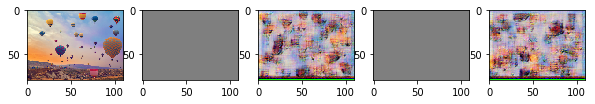

Scale: 0 / Epoch: 1750 / G Loss: 3192.08179 / D Loss: -432.30087


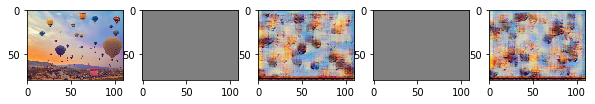

Scale: 0 / Epoch: 2000 / G Loss: 3402.46265 / D Loss: -509.22726


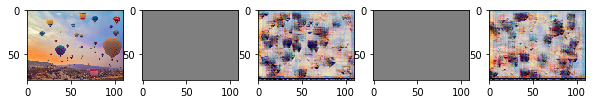

Assignment is finished!
Scale: 1 / Epoch: 250 / G Loss: 3939.21851 / D Loss: -515.75574


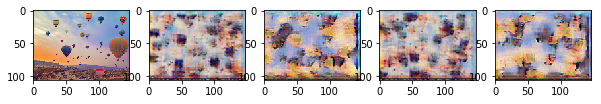

Scale: 1 / Epoch: 500 / G Loss: 3856.47510 / D Loss: -346.38660


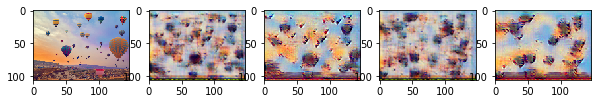

Scale: 1 / Epoch: 750 / G Loss: 3442.90479 / D Loss: -423.76926


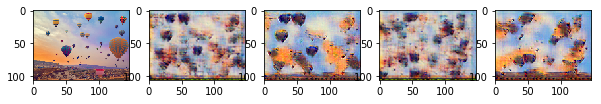

Scale: 1 / Epoch: 1000 / G Loss: 3258.61377 / D Loss: -336.92038


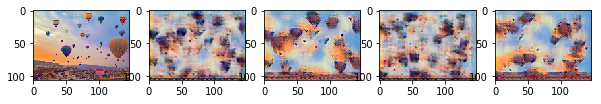

Scale: 1 / Epoch: 1250 / G Loss: 3379.81958 / D Loss: -374.32727


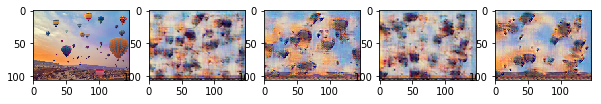

Scale: 1 / Epoch: 1500 / G Loss: 3211.93652 / D Loss: -361.50235


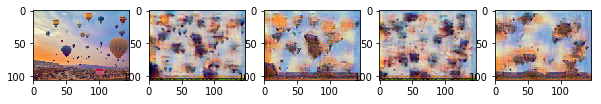

Scale: 1 / Epoch: 1750 / G Loss: 3068.83276 / D Loss: -337.70227


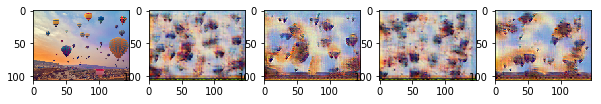

Scale: 1 / Epoch: 2000 / G Loss: 3109.64771 / D Loss: -419.81262


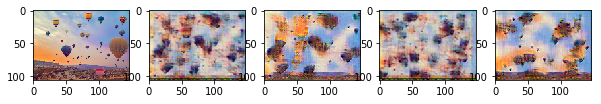

Assignment is finished!
Scale: 2 / Epoch: 250 / G Loss: 3321.12769 / D Loss: -406.77655


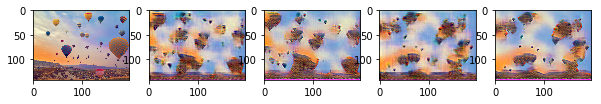

Scale: 2 / Epoch: 500 / G Loss: 2966.80859 / D Loss: -465.96039


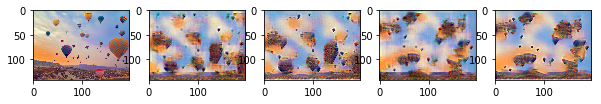

Scale: 2 / Epoch: 750 / G Loss: 2986.16772 / D Loss: -498.32721


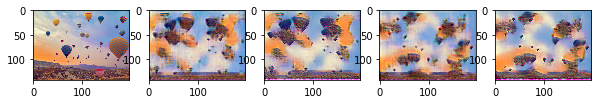

Scale: 2 / Epoch: 1000 / G Loss: 2654.47412 / D Loss: -419.19467


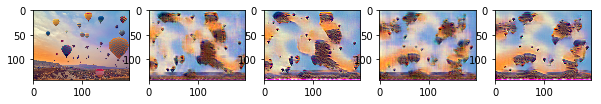

Scale: 2 / Epoch: 1250 / G Loss: 2645.64111 / D Loss: -518.19769


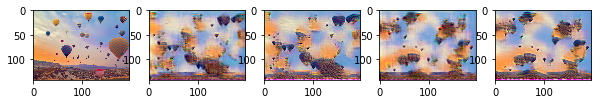

Scale: 2 / Epoch: 1500 / G Loss: 2488.95850 / D Loss: -456.81238


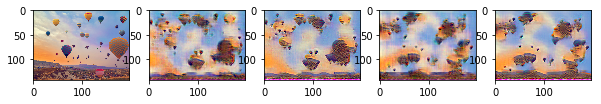

Scale: 2 / Epoch: 1750 / G Loss: 2773.69873 / D Loss: -483.22375


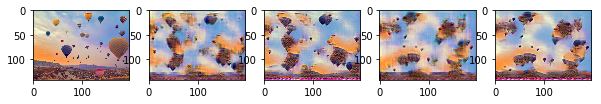

Scale: 2 / Epoch: 2000 / G Loss: 3066.27222 / D Loss: -627.29968


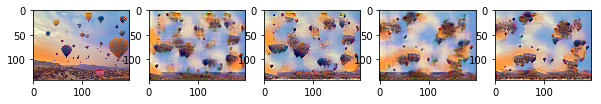

Assignment is finished!
Scale: 3 / Epoch: 250 / G Loss: 2306.57739 / D Loss: -255.48280


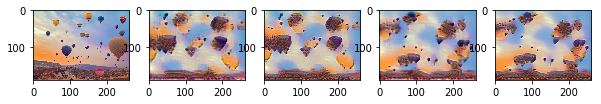

Scale: 3 / Epoch: 500 / G Loss: 2472.85059 / D Loss: -216.05582


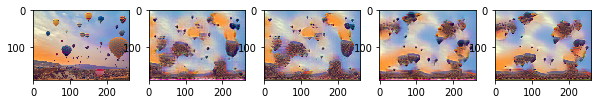

Scale: 3 / Epoch: 750 / G Loss: 2301.05493 / D Loss: -208.52310


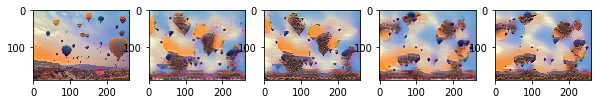

Scale: 3 / Epoch: 1000 / G Loss: 2881.37085 / D Loss: -308.91299


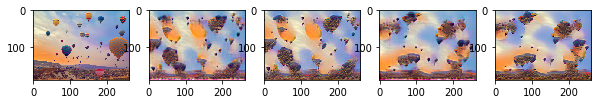

Scale: 3 / Epoch: 1250 / G Loss: 3007.37866 / D Loss: -258.79163


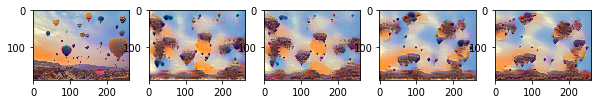

Scale: 3 / Epoch: 1500 / G Loss: 3177.85083 / D Loss: -313.16296


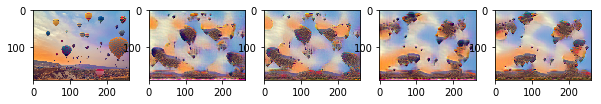

Scale: 3 / Epoch: 1750 / G Loss: 2890.08276 / D Loss: -318.64865


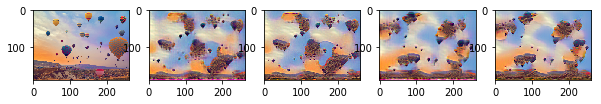

Scale: 3 / Epoch: 2000 / G Loss: 2636.36304 / D Loss: -361.37958


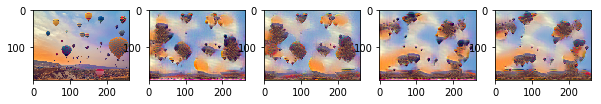

Assignment is finished!
Scale: 4 / Epoch: 250 / G Loss: 2466.14478 / D Loss: -356.87939


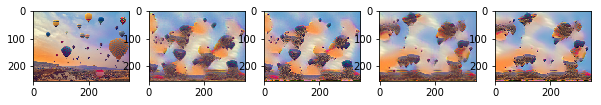

Scale: 4 / Epoch: 500 / G Loss: 2257.01050 / D Loss: -267.45746


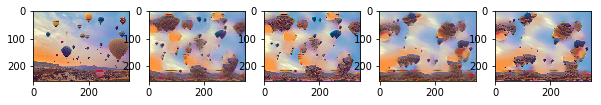

Scale: 4 / Epoch: 750 / G Loss: 1556.50061 / D Loss: -339.97528


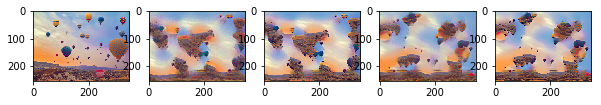

Scale: 4 / Epoch: 1000 / G Loss: 2055.39258 / D Loss: -173.22148


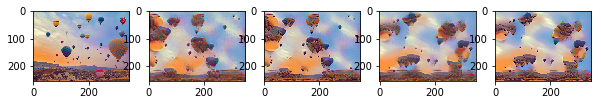

Scale: 4 / Epoch: 1250 / G Loss: 2017.30090 / D Loss: -304.60904


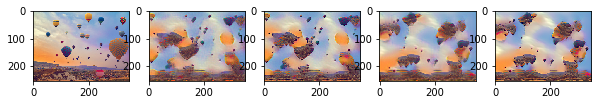

Scale: 4 / Epoch: 1500 / G Loss: 1697.39221 / D Loss: -285.73831


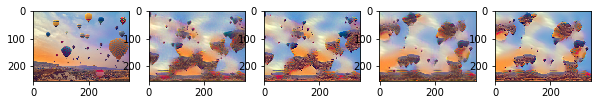

Scale: 4 / Epoch: 1750 / G Loss: 1906.74548 / D Loss: -325.20242


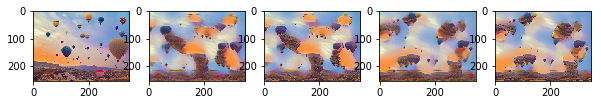

Scale: 4 / Epoch: 2000 / G Loss: 1578.32642 / D Loss: -362.19061


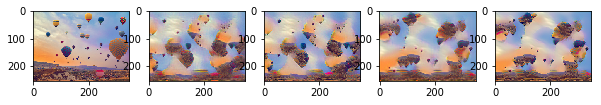

Assignment is finished!
Scale: 5 / Epoch: 250 / G Loss: 1595.95618 / D Loss: -270.39398


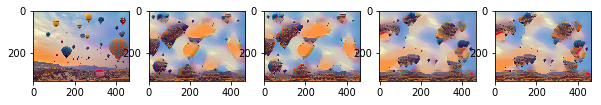

Scale: 5 / Epoch: 500 / G Loss: 1368.03833 / D Loss: -314.37952


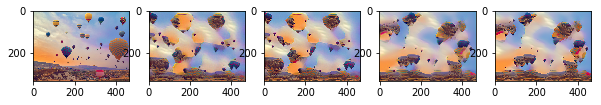

Scale: 5 / Epoch: 750 / G Loss: 1453.86975 / D Loss: -364.79810


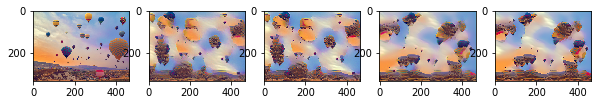

Scale: 5 / Epoch: 1000 / G Loss: 1493.93286 / D Loss: -378.26324


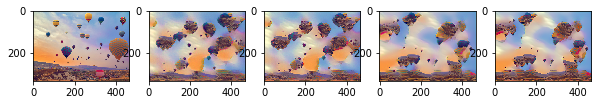

Scale: 5 / Epoch: 1250 / G Loss: 1005.10138 / D Loss: -291.40662


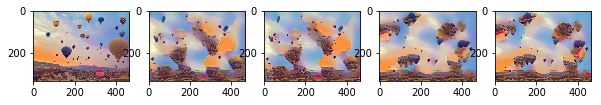

Scale: 5 / Epoch: 1500 / G Loss: 1245.69958 / D Loss: -316.55127


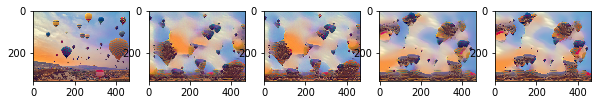

Scale: 5 / Epoch: 1750 / G Loss: 1469.68689 / D Loss: -339.04828


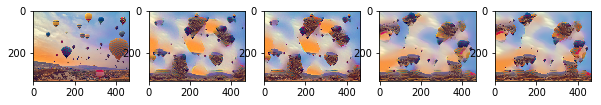

Scale: 5 / Epoch: 2000 / G Loss: 1773.75891 / D Loss: -393.51276


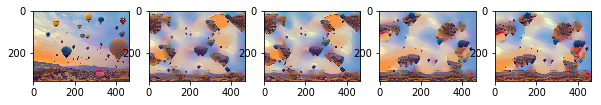

Assignment is finished!
Scale: 6 / Epoch: 250 / G Loss: 995.99561 / D Loss: -235.61458


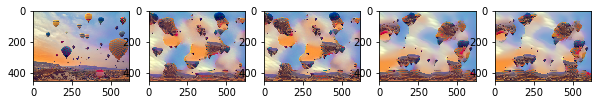

Scale: 6 / Epoch: 500 / G Loss: 1378.16223 / D Loss: -383.91785


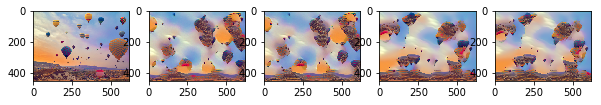

In [ ]:
set_noise = noise_fix(img_size_set)
if train_model:

    iteration = 0
    for i in range(num_scale):
        for j in range(num_epoch[i]):
            if (i != 0) and (j == 0):
                if filters[i] == filters[i-1]:
                    for k in range(len(network.var_gen[str(i)])):
                        network.sess.run(network.var_gen[str(i)][k].assign(network.var_gen[str(i-1)][k]))
                    for k in range(len(network.var_dis[str(i)])):
                        network.sess.run(network.var_dis[str(i)][k].assign(network.var_dis[str(i-1)][k]))
                    print("Assignment is finished!")

            if (i != 0):
                learning_rate = learning_rate*0.99995

            feed_dict = {network.learning_rate: learning_rate,
                         network.inp[str(0)]: [np.zeros(img_size_set[0])],
                         network.noise[str(0)]: img_noise(img_size_set[0]),
                         network.inp_fix[str(0)]: [np.zeros(img_size_set[0])],
                         network.noise_fix[str(0)]: set_noise[0],
                         network.real[str(0)]: [img_N[0]]}

            for k in range(i):
                fake, fake_fix = network.sess.run([network.fake[str(k)], network.fake_fix[str(k)]],
                                                  feed_dict = feed_dict)
                feed_dict[network.inp[str(k+1)]] = img_resize(fake[0], img_size_set[k+1])
                feed_dict[network.inp_fix[str(k+1)]] = img_resize(fake_fix[0], img_size_set[k+1])

                feed_dict[network.noise[str(k+1)]] = img_noise(img_size_set[k+1])
                feed_dict[network.noise_fix[str(k+1)]] = set_noise[k+1]
                feed_dict[network.real[str(k+1)]] = [img_N[k+1]]

            for _ in range(iter_grad):
                _, loss_gen = network.sess.run([network.opt_gen[str(i)], network.loss_gen[str(i)]],
                                               feed_dict=feed_dict)
            for _ in range(iter_grad):    
                _, loss_dis = network.sess.run([network.opt_dis[str(i)], network.loss_dis[str(i)]],
                                               feed_dict=feed_dict)

            fake, inp = network.sess.run([network.fake[str(i)], network.inp[str(i)]], feed_dict=feed_dict)
            fake_fix, inp_fix = network.sess.run([network.fake_fix[str(i)], network.inp_fix[str(i)]], feed_dict=feed_dict)
            fake = denorm(fake)
            inp = denorm(inp)
            fake_fix = denorm(fake_fix)
            inp_fix = denorm(inp_fix)

            if j % 250 == 249:
                print("Scale: {} / Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i) ,(j+1), loss_gen, loss_dis))
                fig, ax = plt.subplots(1,5, figsize=[10,50])
                ax[0].imshow(denorm(img_N[i]))
                ax[1].imshow(inp[0])
                ax[2].imshow(fake[0])
                ax[3].imshow(inp_fix[0])
                ax[4].imshow(fake_fix[0])
                plt.show()
            iteration += 1
            
    Saver.save(network.sess, save_path)

In [ ]:
# image test

fig, ax = plt.subplots(3,3, figsize=[15,15])
for i in range(9):
    feed_dict = {network.inp[str(0)]: [np.zeros(img_size_set[0])],
                 network.noise[str(0)]: img_noise(img_size_set[0]),
                 network.inp_fix[str(0)]: [np.zeros(img_size_set[0])],
                 network.noise_fix[str(0)]: set_noise[0],
                 network.real[str(0)]: [img_N[0]]}

    for k in range(num_scale - 1):
        fake, fake_fix = network.sess.run([network.fake[str(k)], network.fake_fix[str(k)]],
                                          feed_dict = feed_dict)
        feed_dict[network.inp[str(k+1)]] = img_resize(fake[0], img_size_set[k+1])
        feed_dict[network.inp_fix[str(k+1)]] = img_resize(fake_fix[0], img_size_set[k+1])
        feed_dict[network.noise[str(k+1)]] = img_noise(img_size_set[k+1])
        feed_dict[network.noise_fix[str(k+1)]] = set_noise[k+1]
        feed_dict[network.real[str(k+1)]] = [img_N[k+1]]

    fake, inp = network.sess.run([network.fake[str(num_scale-1)], network.inp[str(num_scale-1)]], feed_dict=feed_dict)
    index = [int(i/3), i%3]
    ax[index[0]][index[1]].imshow(denorm(fake[0]))
    ax[index[0]][index[1]].axis('off')
    fig.tight_layout()

## IMAGE TEST

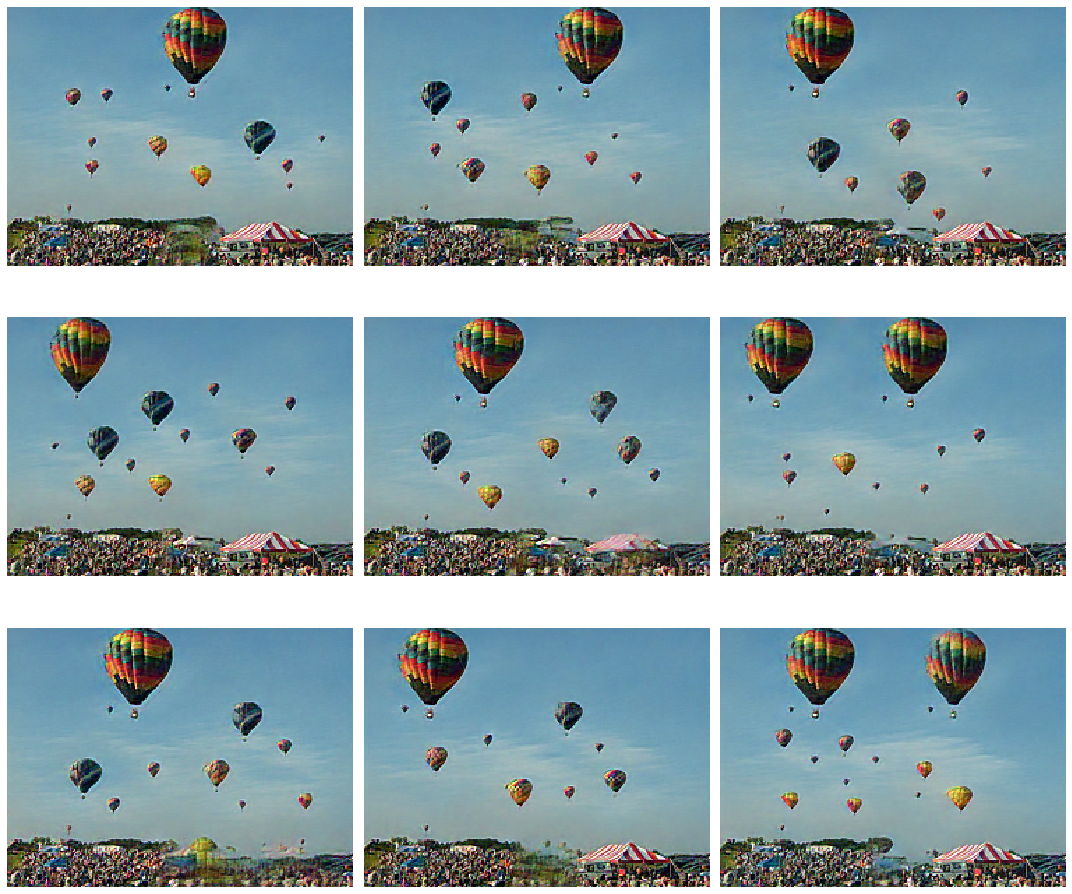

In [13]:
fig, ax = plt.subplots(3,3, figsize=[15,15])
for i in range(9):
    feed_dict = {network.inp[str(0)]: [np.zeros(img_size_set[0])],
                 network.noise[str(0)]: img_noise(img_size_set[0]),
                 network.inp_fix[str(0)]: [np.zeros(img_size_set[0])],
                 network.noise_fix[str(0)]: set_noise[0],
                 network.real[str(0)]: [img_N[0]]}

    for k in range(num_scale - 1):
        fake, fake_fix = network.sess.run([network.fake[str(k)], network.fake_fix[str(k)]],
                                          feed_dict = feed_dict)
        feed_dict[network.inp[str(k+1)]] = img_resize(fake[0], img_size_set[k+1])
        feed_dict[network.inp_fix[str(k+1)]] = img_resize(fake_fix[0], img_size_set[k+1])
        feed_dict[network.noise[str(k+1)]] = img_noise(img_size_set[k+1])
        feed_dict[network.noise_fix[str(k+1)]] = set_noise[k+1]
        feed_dict[network.real[str(k+1)]] = [img_N[k+1]]

    fake, inp = network.sess.run([network.fake[str(num_scale-1)], network.inp[str(num_scale-1)]], feed_dict=feed_dict)
    index = [int(i/3), i%3]
    ax[index[0]][index[1]].imshow(denorm(fake[0]))
    ax[index[0]][index[1]].axis('off')
    fig.tight_layout()

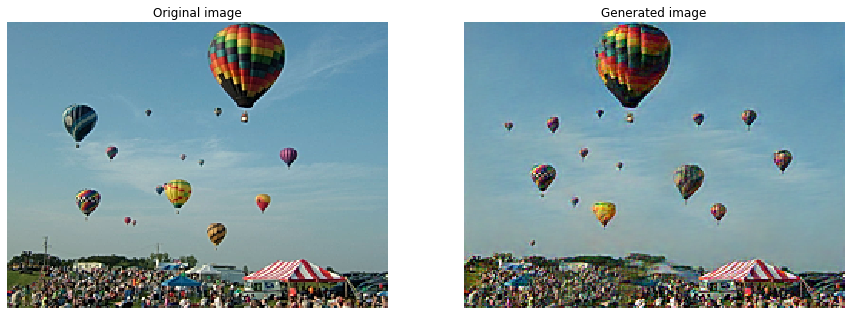

In [12]:
feed_dict = {network.inp[str(0)]: [np.zeros(img_size_set[0])],
             network.noise[str(0)]: img_noise(img_size_set[0]),
             network.inp_fix[str(0)]: [np.zeros(img_size_set[0])],
             network.noise_fix[str(0)]: set_noise[0],
             network.real[str(0)]: [img_N[0]]}
fig, ax = plt.subplots(1,2, figsize=[15,30])
ax[0].imshow((img_N[-1] + 1) / 2)
ax[0].set_title('Original image')
ax[1].set_title('Generated image')
ax[0].axis('off')
ax[1].axis('off')
for k in range(num_scale - 1):
    fake, fake_fix = network.sess.run([network.fake[str(k)], network.fake_fix[str(k)]],
                                      feed_dict = feed_dict)
    feed_dict[network.inp[str(k+1)]] = img_resize(fake[0], img_size_set[k+1])
    feed_dict[network.inp_fix[str(k+1)]] = img_resize(fake_fix[0], img_size_set[k+1])
    feed_dict[network.noise[str(k+1)]] = img_noise(img_size_set[k+1])
    feed_dict[network.noise_fix[str(k+1)]] = set_noise[k+1]
    feed_dict[network.real[str(k+1)]] = [img_N[k+1]]
    
fake, inp = network.sess.run([network.fake[str(num_scale-1)], network.inp[str(num_scale-1)]], feed_dict=feed_dict)
ax[1].imshow(denorm(fake[0]))